# k-NN

by Kirill Bykov, Oleg Vlasovets, Ilya

In [1]:
#imports
import pandas as pd #pandas for reading csv file
import numpy as np  #numpy for vectorising
from random import randrange
import seaborn as sns
from scipy.spatial import distance_matrix
from tqdm import tqdm
import warnings
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def read_MNIST(file_path):
    df = pd.read_csv(file_path, header = None)
    Y = np.array(df[0])
    X = np.array(df.iloc[:,1:])
    return X, Y

def distance(A, B, metric = "euclidean"):
    if metric == "euclidean":
        return np.linalg.norm(A-B)

def first_most_frequent(arr):
    c = 0
    num = arr[0]
    for i in arr:
        amount_times = arr.count(i)
        if amount_times > c:
            c = amount_times
            num = i
    return num

def accuracy(Y_pred, Y_true):
    return np.mean(1 - np.equal(Y_true, Y_pred, dtype=int))

In [3]:
class kNN:
    
    def __init__(self, X_train, Y_train, p = 2):
        self.X_train = X_train
        self.Y_train = Y_train
        self.length = len(X_train)
        self.p = p
        self.inner_distances_calculated = False

    def vote(self, NN):
        n = len(NN)
        votes = np.zeros(n).astype(int)
        for i in range(0, n):
            votes[i] = first_most_frequent([self.Y_train[j] for j in NN[i]])
        return votes
    
    def predict(self, X_test, k):
        n_test = len(X_test)
        D = np.zeros((n_test, self.length))
        NN = np.zeros((n_test,k)).astype(int)
        D = distance_matrix(X_test, self.X_train, self.p)
        for i in range(0, n_test):
            NN[i] = D[i].argsort()[:k]
        return self.vote(NN)
    
    def LOOCV(self, k):
        if not self.inner_distances_calculated:
            print("Calculating distances. This could take some time ...")
            self.inner_distances = distance_matrix(X_train, X_train, self.p);
            self.inner_NN = np.zeros((self.length,self.length)).astype(int)
            for i in range(0,self.length):
                self.inner_NN[i] = self.inner_distances[i].argsort()
            self.inner_distances_calculated = True

        return self.vote(self.inner_NN[:,1:k+1])
    
    def LOOCV_big(self, k):
        if not self.inner_distances_calculated or self.inner_NN.shape[1]<k:
            print("Calculating distances. This could take some time ...")
            self.inner_NN = []
            for i in range(self.length):
                D = distance_matrix([X_train[i]], X_train, self.p);
                NN = D[0].argsort()[1:k+1]
                self.inner_NN.append(NN)
            self.inner_NN = np.array(self.inner_NN)
        
        return self.vote(self.inner_NN[:,:k])

### a)

In [ ]:
results_test = []
results_train = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
X_test, Y_test = read_MNIST("data/MNIST_test_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred_test = classifier.predict(X_test, k)
    results_test.append(accuracy(Y_pred_test, Y_test))
    
    Y_pred_train = classifier.predict(X_train, k)
    results_train.append(accuracy(Y_pred_train, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=results_test, label = 'Test accuracy')
ax = sns.lineplot(x=[i for i in range(1,21)], y=results_train, label = 'Train accuracy')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  5%|▌         | 1/20 [05:06<1:36:54, 306.00s/it]

Сделайте только картинку получше

## LOOCV

*LOOCV* --- метод, который в первый раз считает расстояния между всеми точками, а затем при различных k использует уже посчитанную матрицу расстояний. Так как в памяти храним все расстояния, работает быстро, но только для маленьгоко датасета

*LOOCV_big* --- метод для работы с большими датасетами, нужно запускать начиная с максимального k, так как на первом запуске держим в памяти только соседей, и не надо пересчитывать это все для маленьких k

  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


100%|██████████| 20/20 [01:53<00:00,  5.67s/it]


[0.08066666666666666, 0.08066666666666666, 0.073, 0.073, 0.07833333333333334, 0.079, 0.08166666666666667, 0.08233333333333333, 0.08333333333333333, 0.08866666666666667, 0.088, 0.089, 0.09233333333333334, 0.093, 0.09433333333333334, 0.095, 0.09566666666666666, 0.09566666666666666, 0.098, 0.09833333333333333]


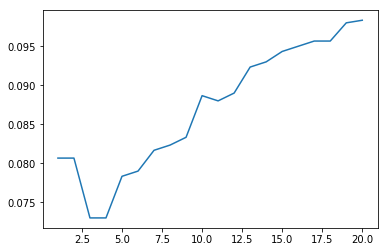

In [4]:
LOOCV_results = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(1,21)):
    Y_pred = classifier.LOOCV(k)
    LOOCV_results.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results)
print(LOOCV_results)

In [6]:
LOOCV_results_Mink = []
X_train, Y_train = read_MNIST("data/MNIST_train_small.csv")
classifier = kNN(X_train, Y_train)

for p in tqdm(range(1,16)):
    classifier.p = p
    for k in tqdm(range(1,21)):
        Y_pred = classifier.LOOCV(k)
        LOOCV_results_Mink.append(accuracy(Y_pred, Y_train))
    classifier.inner_distances_calculated = False



  0%|          | 0/15 [00:00<?, ?it/s]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [01:21<25:50, 81.59s/it]


 40%|████      | 8/20 [01:21<11:25, 57.12s/it]


 60%|██████    | 12/20 [01:21<05:19, 39.99s/it]


 75%|███████▌  | 15/20 [01:21<02:20, 28.01s/it]


 90%|█████████ | 18/20 [01:22<00:39, 19.62s/it]


100%|██████████| 20/20 [01:22<00:00,  4.11s/it]

  7%|▋         | 1/15 [01:22<19:11, 82.24s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [01:56<36:45, 116.07s/it]


 45%|████▌     | 9/20 [01:56<14:53, 81.25s/it] 


 65%|██████▌   | 13/20 [01:56<06:38, 56.89s/it]


 80%|████████  | 16/20 [01:56<02:39, 39.83s/it]


 95%|█████████▌| 19/20 [01:56<00:27, 27.90s/it]


100%|██████████| 20/20 [01:56<00:00,  5.83s/it]

 13%|█▎        | 2/15 [03:18<20:03, 92.55s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:02<38:48, 122.56s/it]


 40%|████      | 8/20 [02:02<17:09, 85.80s/it] 


 60%|██████    | 12/20 [02:02<08:00, 60.07s/it]


 75%|███████▌  | 15/20 [02:02<03:30, 42.06s/it]


 90%|█████████ | 18/20 [02:03<00:58, 29.45s/it]


100%|██████████| 20/20 [02:03<00:00,  6.16s/it]

 20%|██        | 3/15 [05:21<20:20, 101.73s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:10<41:10, 130.05s/it]


 45%|████▌     | 9/20 [02:10<16:41, 91.04s/it] 


 65%|██████▌   | 13/20 [02:10<07:26, 63.73s/it]


 80%|████████  | 16/20 [02:10<02:58, 44.62s/it]


 95%|█████████▌| 19/20 [02:10<00:31, 31.26s/it]


100%|██████████| 20/20 [02:10<00:00,  6.53s/it]

 27%|██▋       | 4/15 [07:32<20:14, 110.41s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:07<40:29, 127.84s/it]


 40%|████      | 8/20 [02:07<17:53, 89.50s/it] 


 60%|██████    | 12/20 [02:08<08:21, 62.66s/it]


 75%|███████▌  | 15/20 [02:08<03:39, 43.87s/it]


 90%|█████████ | 18/20 [02:08<01:01, 30.73s/it]


100%|██████████| 20/20 [02:08<00:00,  6.42s/it]

 33%|███▎      | 5/15 [09:41<19:18, 115.84s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:06<39:59, 126.32s/it]


 45%|████▌     | 9/20 [02:06<16:12, 88.43s/it] 


 65%|██████▌   | 13/20 [02:06<07:13, 61.91s/it]


 80%|████████  | 16/20 [02:06<02:53, 43.35s/it]


 95%|█████████▌| 19/20 [02:06<00:30, 30.36s/it]


100%|██████████| 20/20 [02:06<00:00,  6.34s/it]

 40%|████      | 6/15 [11:48<17:52, 119.15s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...


C:\ProgramData\Anaconda3\lib\site-packages\scipy\spatial\kdtree.py:74: RuntimeWarning: invalid value encountered in power
  return minkowski_distance_p(x, y, p)**(1./p)



  5%|▌         | 1/20 [02:10<41:19, 130.48s/it]


 45%|████▌     | 9/20 [02:10<16:44, 91.34s/it] 


 65%|██████▌   | 13/20 [02:10<07:27, 63.94s/it]


 80%|████████  | 16/20 [02:10<02:59, 44.77s/it]


 95%|█████████▌| 19/20 [02:10<00:31, 31.36s/it]


100%|██████████| 20/20 [02:11<00:00,  6.55s/it]

 47%|████▋     | 7/15 [13:59<16:21, 122.72s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:16<43:17, 136.71s/it]


 45%|████▌     | 9/20 [02:16<17:32, 95.70s/it] 


 65%|██████▌   | 13/20 [02:16<07:48, 67.00s/it]


 80%|████████  | 16/20 [02:17<03:07, 46.91s/it]


 95%|█████████▌| 19/20 [02:17<00:32, 32.85s/it]


100%|██████████| 20/20 [02:17<00:00,  6.86s/it]

 53%|█████▎    | 8/15 [16:16<14:49, 127.08s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:14<42:29, 134.21s/it]


 45%|████▌     | 9/20 [02:14<17:13, 93.95s/it] 


 65%|██████▌   | 13/20 [02:14<07:40, 65.77s/it]


 80%|████████  | 16/20 [02:14<03:04, 46.05s/it]


 95%|█████████▌| 19/20 [02:14<00:32, 32.25s/it]


100%|██████████| 20/20 [02:14<00:00,  6.74s/it]

 60%|██████    | 9/15 [18:31<12:56, 129.37s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:12<41:57, 132.52s/it]


 45%|████▌     | 9/20 [02:12<17:00, 92.77s/it] 


 65%|██████▌   | 13/20 [02:12<07:34, 64.95s/it]


 80%|████████  | 16/20 [02:12<03:01, 45.48s/it]


 95%|█████████▌| 19/20 [02:13<00:31, 31.85s/it]


100%|██████████| 20/20 [02:13<00:00,  6.66s/it]

 67%|██████▋   | 10/15 [20:44<10:52, 130.50s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:09<40:53, 129.12s/it]


 45%|████▌     | 9/20 [02:09<16:34, 90.39s/it] 


 65%|██████▌   | 13/20 [02:09<07:22, 63.28s/it]


 80%|████████  | 16/20 [02:09<02:57, 44.31s/it]


 95%|█████████▌| 19/20 [02:09<00:31, 31.03s/it]


100%|██████████| 20/20 [02:09<00:00,  6.48s/it]

 73%|███████▎  | 11/15 [22:53<08:40, 130.25s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:14<42:30, 134.21s/it]


 45%|████▌     | 9/20 [02:14<17:13, 93.95s/it] 


 65%|██████▌   | 13/20 [02:14<07:40, 65.78s/it]


 80%|████████  | 16/20 [02:14<03:04, 46.06s/it]


 95%|█████████▌| 19/20 [02:14<00:32, 32.26s/it]


100%|██████████| 20/20 [02:14<00:00,  6.74s/it]

 80%|████████  | 12/15 [25:08<06:34, 131.63s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:06<40:00, 126.37s/it]


 40%|████      | 8/20 [02:06<17:41, 88.46s/it] 


 65%|██████▌   | 13/20 [02:06<07:13, 61.93s/it]


 80%|████████  | 16/20 [02:06<02:53, 43.36s/it]


 95%|█████████▌| 19/20 [02:06<00:30, 30.37s/it]


100%|██████████| 20/20 [02:06<00:00,  6.35s/it]

 87%|████████▋ | 13/15 [27:15<04:20, 130.22s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:12<41:59, 132.61s/it]


 45%|████▌     | 9/20 [02:12<17:01, 92.83s/it] 


 65%|██████▌   | 13/20 [02:12<07:34, 64.99s/it]


 80%|████████  | 16/20 [02:12<03:02, 45.50s/it]


 95%|█████████▌| 19/20 [02:13<00:31, 31.87s/it]


100%|██████████| 20/20 [02:13<00:00,  6.66s/it]

 93%|█████████▎| 14/15 [29:28<02:11, 131.12s/it]


  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...





  5%|▌         | 1/20 [02:11<41:31, 131.14s/it]


 40%|████      | 8/20 [02:11<18:21, 91.80s/it] 


 65%|██████▌   | 13/20 [02:11<07:29, 64.27s/it]


 80%|████████  | 16/20 [02:11<03:00, 45.00s/it]


 95%|█████████▌| 19/20 [02:11<00:31, 31.52s/it]


100%|██████████| 20/20 [02:11<00:00,  6.58s/it]

100%|██████████| 15/15 [31:40<00:00, 131.29s/it]



ValueError: arrays must all be same length

[0.08966666666666667, 0.08966666666666667, 0.09, 0.083, 0.09133333333333334, 0.09033333333333333, 0.097, 0.09066666666666667, 0.09666666666666666, 0.097, 0.09933333333333333, 0.101, 0.103, 0.10233333333333333, 0.10766666666666666, 0.107, 0.10966666666666666, 0.11033333333333334, 0.111, 0.11266666666666666, 0.08066666666666666, 0.08066666666666666, 0.073, 0.073, 0.07833333333333334, 0.079, 0.08166666666666667, 0.08233333333333333, 0.08333333333333333, 0.08866666666666667, 0.088, 0.089, 0.09233333333333334, 0.093, 0.09433333333333334, 0.095, 0.09566666666666666, 0.09566666666666666, 0.098, 0.09833333333333333, 0.07533333333333334, 0.07533333333333334, 0.06633333333333333, 0.069, 0.07333333333333333, 0.07733333333333334, 0.078, 0.07766666666666666, 0.07966666666666666, 0.08366666666666667, 0.08466666666666667, 0.08533333333333333, 0.086, 0.08466666666666667, 0.09133333333333334, 0.09, 0.09333333333333334, 0.09066666666666667, 0.096, 0.09533333333333334, 0.07333333333333333, 0.073333333333

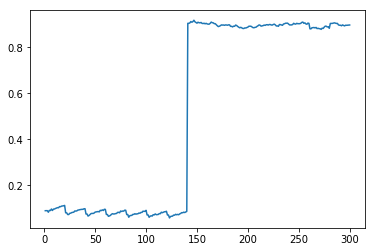

In [7]:
ax = sns.lineplot(x=[i for i in range(1,301)], y=LOOCV_results_Mink)
print(LOOCV_results_Mink)

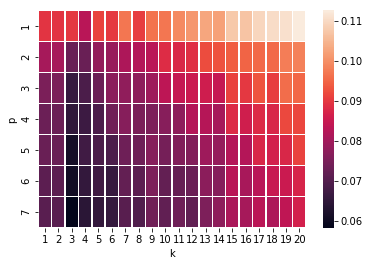

In [14]:
ax = sns.heatmap(np.reshape(LOOCV_results_Mink[:140], (7,20)), linewidth=0.5)
plt.xlabel('k')
plt.ylabel('p')
ax.set_xticklabels(range(1,21))
ax.set_yticklabels(range(1,8))
plt.show()

In [ ]:
LOOCV_results_full = []
X_train, Y_train = read_MNIST("../../MNIST_train.csv")
classifier = kNN(X_train, Y_train)

for k in tqdm(range(20,0,-1)):
    Y_pred = classifier.LOOCV_big(k)
    LOOCV_results_full.append(accuracy(Y_pred, Y_train))

ax = sns.lineplot(x=[i for i in range(1,21)], y=LOOCV_results_full)
print(LOOCV_results_full)



  0%|          | 0/20 [00:00<?, ?it/s]

Calculating distances. This could take some time ...
